Accuracy: 0.9300911854103343


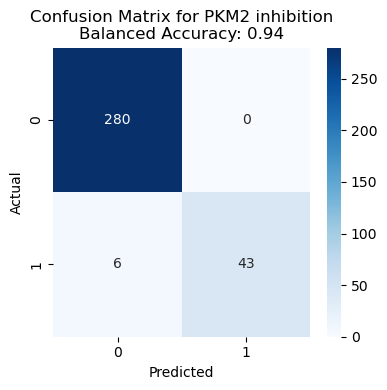

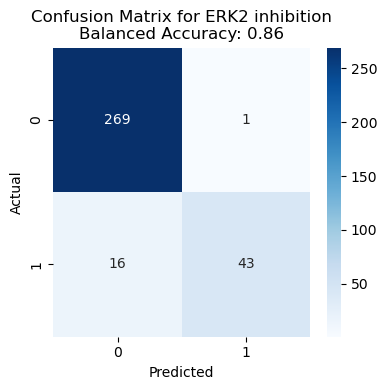

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the data
file_path = r"sorted_tested_molecules.csv"
df = pd.read_csv(file_path)

def line_multiplication_class_balancing(df, dupe_amount):
    # Filter for rows where both PKM2_inhibition and ERK2_inhibition are 1
    ones_filter = (df['PKM2_inhibition'] == 1) & (df['ERK2_inhibition'] == 1)
    
    # Select only rows that satisfy the filter
    filtered_df = df[ones_filter]
    
    # Randomly select indices from filtered_df to duplicate
    random_selection = np.random.choice(filtered_df.index, size=dupe_amount, replace=True)
    
    # Duplicate the selected rows
    duped_rows = df.loc[random_selection]
    
    # Concatenate original dataframe and duplicated rows
    balanced_df = pd.concat([df, duped_rows], ignore_index=True)
    
    return balanced_df

balanced_df = line_multiplication_class_balancing(df, 200)

# Select the first 10 features and the target variables
X = balanced_df.iloc[:, :20]  # Select the first 10 columns
y = balanced_df[['PKM2_inhibition', 'ERK2_inhibition']]

# Convert data to float32
X = X.astype(np.float32)
y = y.astype(np.float32)

# Split the rare data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Create a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)

# Train the model using the training sets
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Adding the actual and predicted values to a new dataframe with molecule names
results_df = pd.DataFrame({
    'PKM2_actual': y_test['PKM2_inhibition'].values,
    'ERK2_actual': y_test['ERK2_inhibition'].values,
    'PKM2_predicted': y_pred[:, 0],
    'ERK2_predicted': y_pred[:, 1]
})

# Save to new CSV
output_file_path = "predicted_molecules.csv"
results_df.to_csv(output_file_path, index=False)

def balanced_accuracy_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    sensitivities = []

    for i in range(num_classes):
        true_positives = cm[i, i]
        actual_positives = cm[i, :].sum()
        sensitivity = true_positives / actual_positives
        sensitivities.append(sensitivity)

    balanced_accuracy = sum(sensitivities) / num_classes
    return balanced_accuracy

y_pred1 = y_pred[:, 0]
y_pred2 = y_pred[:, 1]

y_true1 = y_test['PKM2_inhibition'].values
y_true2 = y_test['ERK2_inhibition'].values

def cm_plot(y_true, y_pred, class_name):
    # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    # Title with class name and balanced accuracy
    plt.title(f"Confusion Matrix for {class_name} inhibition\nBalanced Accuracy: {balanced_acc:.2f}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Plot confusion matrix for ERK2 inhibition
cm_plot(y_true1, y_pred1, class_name='PKM2')

# Plot confusion matrix for PKM2 inhibition
cm_plot(y_true2, y_pred2, class_name='ERK2')

# Read in new csv
df = pd.read_csv("untested_2D_descriptors.csv")



PKM2 Model Accuracy: 0.9817629179331308
ERK2 Model Accuracy: 0.9513677811550152
PKM2 Model Balanced Accuracy: 0.9387755102040816
ERK2 Model Balanced Accuracy: 0.8644067796610169


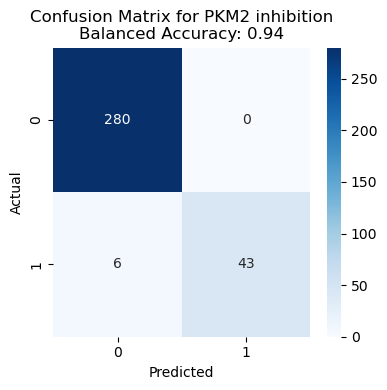

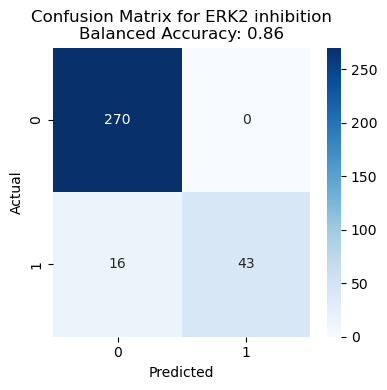

Predictions saved to 'prediction_rf_keys.csv'
PKM2 Inhibition Predictions: 4
ERK2 Inhibition Predictions: 4


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the train dataset
train_path = 'Train set with MACCS keys.csv'
train_data = pd.read_csv(train_path)

def line_multiplication_class_balancing(df, dupe_amount):
    # Filter for rows where both PKM2_inhibition and ERK2_inhibition are 1
    ones_filter = (df['PKM2_inhibition'] == 1) & (df['ERK2_inhibition'] == 1)
    
    # Select only rows that satisfy the filter
    filtered_df = df[ones_filter]
    
    # Randomly select indices from filtered_df to duplicate
    random_selection = np.random.choice(filtered_df.index, size=dupe_amount, replace=True)
    
    # Duplicate the selected rows
    duped_rows = df.loc[random_selection]
    
    # Concatenate original dataframe and duplicated rows
    balanced_df = pd.concat([df, duped_rows], ignore_index=True)
    
    return balanced_df

train_data = line_multiplication_class_balancing(train_data, 200)

# Function to convert bitstring into a list of integers
def bitstring_to_list(bitstring):
    return [int(bit) for bit in bitstring.strip('[]').split(', ')]

# Convert MACCS keys bitstrings into lists of integers for the train set
train_data['maccs_keys_list'] = train_data['maccs_keys_bitstring'].apply(bitstring_to_list)

# Extract features and target variables
X = np.array(train_data['maccs_keys_list'].tolist())
y_pkm2 = train_data['PKM2_inhibition']
y_erk2 = train_data['ERK2_inhibition']

# Split the data
X_train, X_val, y_train_pkm2, y_val_pkm2 = train_test_split(X, y_pkm2, test_size=0.25, random_state=42)
_, _, y_train_erk2, y_val_erk2 = train_test_split(X, y_erk2, test_size=0.25, random_state=42)

# Train Random Forest models
rf_pkm2 = RandomForestClassifier(n_estimators=10, random_state=42)
rf_erk2 = RandomForestClassifier(n_estimators=10, random_state=42)

rf_pkm2.fit(X_train, y_train_pkm2)
rf_erk2.fit(X_train, y_train_erk2)

# Evaluate the models
y_pred_val_pkm2 = rf_pkm2.predict(X_val)
y_pred_val_erk2 = rf_erk2.predict(X_val)

accuracy_pkm2 = accuracy_score(y_val_pkm2, y_pred_val_pkm2)
accuracy_erk2 = accuracy_score(y_val_erk2, y_pred_val_erk2)

print("PKM2 Model Accuracy:", accuracy_pkm2)
print("ERK2 Model Accuracy:", accuracy_erk2)

# Balanced Accuracy and Confusion Matrix Plotting Functions
def balanced_accuracy_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    num_classes = cm.shape[0]
    sensitivities = []

    for i in range(num_classes):
        true_positives = cm[i, i]
        actual_positives = cm[i, :].sum()
        sensitivity = true_positives / actual_positives
        sensitivities.append(sensitivity)

    balanced_accuracy = sum(sensitivities) / num_classes
    return balanced_accuracy

def cm_plot(y_true, y_pred, class_name):
    # Calculate balanced accuracy
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    
    # Title with class name and balanced accuracy
    plt.title(f"Confusion Matrix for {class_name} inhibition\nBalanced Accuracy: {balanced_acc:.2f}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Calculate and print balanced accuracy
balanced_accuracy_pkm2 = balanced_accuracy_score(y_val_pkm2, y_pred_val_pkm2)
balanced_accuracy_erk2 = balanced_accuracy_score(y_val_erk2, y_pred_val_erk2)

print("PKM2 Model Balanced Accuracy:", balanced_accuracy_pkm2)
print("ERK2 Model Balanced Accuracy:", balanced_accuracy_erk2)

# Plot confusion matrices
cm_plot(y_val_pkm2, y_pred_val_pkm2, "PKM2")
cm_plot(y_val_erk2, y_pred_val_erk2, "ERK2")

# Load the test dataset
test_path = 'Test set with MACCS keys.csv'
test_data = pd.read_csv(test_path)

# Convert MACCS keys bitstrings into lists of integers for the test set
test_data['maccs_keys_list'] = test_data['maccs_keys_bitstring'].apply(bitstring_to_list)

# Extract features
X_test = np.array(test_data['maccs_keys_list'].tolist())

# Make predictions on the test set
y_test_pred_pkm2 = rf_pkm2.predict(X_test)
y_test_pred_erk2 = rf_erk2.predict(X_test)

# Adding the predicted values to the test dataframe
test_data['PKM2_predicted'] = y_test_pred_pkm2
test_data['ERK2_predicted'] = y_test_pred_erk2

# Select only the required columns
output_df = test_data[['SMILES', 'PKM2_predicted', 'ERK2_predicted']]

# Save predictions to new CSV
output_test_file_path = "prediction_rf_keys.csv"
output_df.to_csv(output_test_file_path, index=False)

print(f"Predictions saved to '{output_test_file_path}'")

# count the number of times a 1 is predicted
pkm2_count = np.count_nonzero(y_test_pred_pkm2)
erk2_count = np.count_nonzero(y_test_pred_erk2)

print(f"PKM2 Inhibition Predictions: {pkm2_count}")
print(f"ERK2 Inhibition Predictions: {erk2_count}")
